In [1]:
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

# Lightning
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning import loggers as pl_loggers

# Lightning bolts
from pl_bolts.datamodules import CIFAR10DataModule, STL10DataModule, ImagenetDataModule
from pl_bolts.models.self_supervised.simclr import SimCLRTrainDataTransform, SimCLREvalDataTransform
from pl_bolts.callbacks.printing import PrintTableMetricsCallback
from pl_bolts.models.regression import LogisticRegression
from pl_bolts.transforms.dataset_normalizations import (
    cifar10_normalization,
    imagenet_normalization,
    stl10_normalization,
)

# Numpy, scipy
import numpy as np
from sklearn.decomposition import PCA
import scipy.stats
import umap

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os
from collections import OrderedDict
from argparse import ArgumentParser

import project_path

In [2]:
from matplotlib.ticker import FormatStrFormatter

In [3]:
from models.module import LPL, SupervisedBaseline, NegSampleBaseline
from metrics.metrics import compute_manifold_measures

In [4]:
outputdir = os.path.expanduser("~/data/plots_of_the_day/lpl/fig_deep_networks")
os.makedirs(outputdir, exist_ok=True)

In [5]:
def get_representations(dataloader, encoder_blocks, return_pixels=False):
    
    representations = [[] for i in range(len(encoder_blocks))]
    pixels = []
    labels = []
    pooler = nn.AdaptiveAvgPool2d((1, 1))
    
    for batch in dataloader:
        x, y = batch
        x = x[-1].to('cuda')
        y = y.to('cuda')
        
        labels.append(y)
        if return_pixels:
            pixels.append(x.view(x.shape[0],-1))
        with torch.no_grad():
            z = x
            for i, block in enumerate(encoder_blocks):
                z = block(z)
                if isinstance(z, tuple):
                    z = z[0]
                z_pooled = pooler(z)
                representations[i].append(z_pooled.squeeze())
    
    labels = torch.cat(labels)
    for i, layer_repr in enumerate(representations):
        representations[i] = torch.cat(layer_repr)
    if return_pixels:
        pixels = torch.cat(pixels)
        return representations, labels, pixels
    else:
        return representations, labels

In [6]:
def evaluate_model(model_type, path):
    
    if model_type == 'lpl':
        model = LPL.load_from_checkpoint(path, strict=False).to('cuda')
        encoder_blocks = model.network.encoder.blocks
    
    elif model_type == 'supervised':
        model = SupervisedBaseline.load_from_checkpoint(path, strict=False).to('cuda')
        encoder_blocks = model.network.encoder.blocks
    
    elif model_type == 'neg-samples':
        model = NegSampleBaseline.load_from_checkpoint(path, strict=False).to('cuda')
        encoder_blocks = model.network.encoder.blocks
        
    val_reprs, val_labels = get_representations(data_module.train_dataloader_labeled(), encoder_blocks)
    test_reprs, test_labels = get_representations(data_module.test_dataloader(), encoder_blocks)
    
    test_readout_acc = []
    participation_ratio = [[], []]
    activity = []
    unit_variance = []
    for i, layer_repr in enumerate(val_reprs):
        _, _, classwise_pr, _ = compute_manifold_measures(layer_repr, val_labels)
        pr = compute_participation_ratio(layer_repr)
        participation_ratio[0].append(pr)
        participation_ratio[1].append(classwise_pr)
        activity.append(layer_repr.mean())
        unit_variance.append(layer_repr.var(dim=0).mean())
        
        train_dataset = TensorDataset(layer_repr, val_labels)
        train_dataloader = DataLoader(train_dataset, batch_size=512)

        test_dataset = TensorDataset(test_reprs[i], test_labels)
        test_dataloader = DataLoader(test_dataset, batch_size=1000)

        linear_evaluator = LogisticRegression(layer_repr.shape[1], data_module.num_classes, learning_rate=1e-3, checkpoint_callback=False).to('cuda')

        readout_trainer = pl.Trainer(gpus=1, max_epochs=20, checkpoint_callback=False)
        readout_trainer.fit(linear_evaluator, train_dataloader)

        # test_readout_acc.append(readout_trainer.test(linear_evaluator, test_dataloader)[0]['test_acc'])
        accuracy = 0.
        count = 0.
        linear_evaluator.to('cuda')
        for x in test_dataloader:
            pred = linear_evaluator(x[0].to('cuda'))
            accuracy += (pred.argmax(dim=-1)==x[1]).sum()
            count += len(x[1])

        test_readout_acc.append(accuracy/count)
        
    return test_readout_acc, participation_ratio, activity, unit_variance

In [7]:
def eval_multi_run(model_type, prefix, suffix):
    
    accs = [[] for i in range(4)]
    prs = [[] for i in range(4)]
    act = [[] for i in range(4)]
    var = [[] for i in range(4)]
    for i, run in enumerate(['1', '2', '3', '4']):
        path = os.path.join(prefix + run, suffix, 'checkpoints')
        for f in os.listdir(path):
            if '.ckpt' in f:
                model_filename = f
                break
        path = os.path.join(path, model_filename)
        accs[i], prs[i], act[i], var[i] = evaluate_model(model_type, path)
    return torch.FloatTensor(accs), torch.FloatTensor(prs), torch.FloatTensor(act), torch.FloatTensor(var)

In [8]:
def compute_participation_ratio(x):
    """
    Calculates participation ratio of the correlation matrix of the input
    pr = (sum of eigenvalues)^2 / sum of (eigenvalues^2)
    :param x: (torch.tensor) input feature tensor (batch x features)
    :return: (torch.tensor)
             participation ratio (singleton tensor)
    """
    x_c = x - x.mean(dim=0)

    corr_matrix = torch.einsum('ij,kj->ik', x_c, x_c)

    eig_vals, _ = torch.linalg.eig(corr_matrix)
    eig_vals = eig_vals.real
    pr = eig_vals.sum() ** 2 / (eig_vals ** 2).sum()

    return pr

In [9]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [10]:
prefix = '/home_fmi/01/srinmanu/data/lpl/stl10/'

# STL-10

In [11]:
prefix = os.path.expanduser("~/data/lpl/stl10/")
model_name = 'lpl'

In [14]:
model = LPL.load_from_checkpoint(os.path.join(prefix,'run_1',model_name,'checkpoints/epoch=799-step=74399.ckpt'), strict=False).to('cuda')

In [15]:
print(model.network.encoder)

VGG11Encoder(
  (blocks): ModuleList(
    (0): ConvBlock(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (module): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (module): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Identity()
      )
    )
    (3): ConvBlock(
      (module): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [15]:
data_dir = os.path.expanduser("~/data/datasets/stl10")
h = 0  # image size

data_module = STL10DataModule(batch_size=500, data_dir=data_dir)
normalization = stl10_normalization()
(c, h, w) = data_module.size()

data_module.train_transforms = SimCLREvalDataTransform(h, normalize=normalization) # We don't use any fancy augmentations during fine-tuning linear readouts
data_module.val_transforms = SimCLREvalDataTransform(h, normalize=normalization)
data_module.test_transforms = SimCLREvalDataTransform(h, normalize=normalization)
data_module.setup()

/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:158: LightningDeprecationWarning: DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `size` was deprecated in v1.5 and will be removed in v1.7.")
/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:144: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")
/ereborfs/manuhalv/venvs/holodeck/lib/python3.

### Pixel-space decoding

In [16]:
_, val_labels, val_pixels = get_representations(data_module.train_dataloader_labeled(), model.network.encoder.blocks, return_pixels=True)
_, test_labels, test_pixels = get_representations(data_module.test_dataloader(), model.network.encoder.blocks, return_pixels=True)

_, _, pixel_participation_ratio, _ = compute_manifold_measures(val_pixels, val_labels)
pixel_activity = val_pixels.mean()
pixel_unit_variance = val_pixels.var(dim=0).mean()
        
train_dataset = TensorDataset(val_pixels, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=512)

test_dataset = TensorDataset(test_pixels, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=1000)

linear_evaluator = LogisticRegression(val_pixels.shape[1], data_module.num_classes, learning_rate=1e-3, checkpoint_callback=False).to('cuda')

readout_trainer = pl.Trainer(gpus=1, max_epochs=20, checkpoint_callback=False)
readout_trainer.fit(linear_evaluator, train_dataloader)

# pixel_readout_acc = readout_trainer.test(linear_evaluator, test_dataloader)[0]['test_acc']
accuracy = 0.
count = 0.
linear_evaluator.to('cuda')
for x in test_dataloader:
    pred = linear_evaluator(x[0].to('cuda'))
    accuracy += (pred.argmax(dim=-1)==x[1]).sum()
    count += len(x[1])

pixel_readout_acc = accuracy/count

/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ereborfs/manuhalv/venv

Training: 0it [00:00, ?it/s]

/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pl_bolts/models/regression/logistic_regression.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)


In [17]:
pixel_readout_acc

tensor(0.3163, device='cuda:0')

In [17]:
prefix = os.path.expanduser("~/data/lpl/stl10/")
model_name = 'lpl'

In [18]:
greedy_lpl_acc, greedy_lpl_dim, greedy_lpl_act, greedy_lpl_var = eval_multi_run('lpl', prefix + 'run_', model_name)
greedy_collapse_acc, greedy_collapse_dim, greedy_collapse_act, greedy_collapse_var = eval_multi_run('lpl', prefix + 'hebb_off_', model_name)
greedy_dimensional_collapse_acc, greedy_dimensional_collapse_dim, greedy_dimensional_collapse_act, greedy_dimensional_collapse_var = eval_multi_run('lpl', prefix + 'decorr_off_', model_name)
greedy_no_pred_acc, greedy_no_pred_dim, greedy_no_pred_act, greedy_no_pred_var = eval_multi_run('lpl', prefix + 'pred_off_', model_name)

/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ereborfs/manuhalv/venv

Training: 0it [00:00, ?it/s]

/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pl_bolts/models/regression/logistic_regression.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   
----------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1.3 K 
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2.6 K 
----------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5.1 K 
----------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [19]:
plt.rcParams['figure.constrained_layout.use'] = True

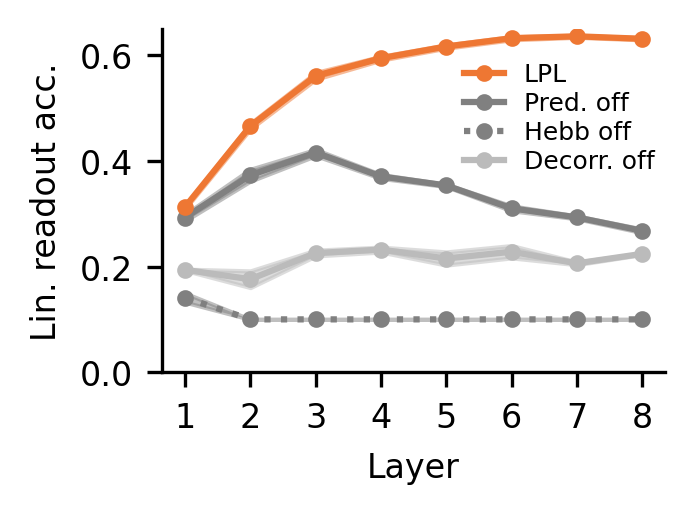

In [20]:
plt.figure(figsize=(2.2,1.6), dpi=300)

vals = greedy_lpl_acc.mean(dim=0)
stderrs = greedy_lpl_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_lpl_acc.mean(dim=0), color='#EE7733', label='LPL', marker='.', zorder=4)
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#EE7733', alpha=0.5)

vals = greedy_no_pred_acc.mean(dim=0)
stderrs = greedy_no_pred_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_no_pred_acc.mean(dim=0), color='gray', label='Pred. off', marker='.', zorder=3)
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_collapse_acc.mean(dim=0)
stderrs = greedy_collapse_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_collapse_acc.mean(dim=0), color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_dimensional_collapse_acc.mean(dim=0)
stderrs = greedy_dimensional_collapse_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_dimensional_collapse_acc.mean(dim=0), color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Lin. readout acc.', fontsize=8)
plt.xticks(range(1,9))
plt.ylim(0,0.65)

lgd = plt.legend(frameon=False, fontsize=6, handlelength=1.6, loc=(0.58,0.55), labelspacing=0.2)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
sns.despine()

plt.savefig(os.path.join(outputdir,'deep_net_layerwise_acc_stl.pdf'), bbox_inches='tight', backend='pgf')

In [24]:
global_dim_idx = 0
classwise_dim_idx = 1

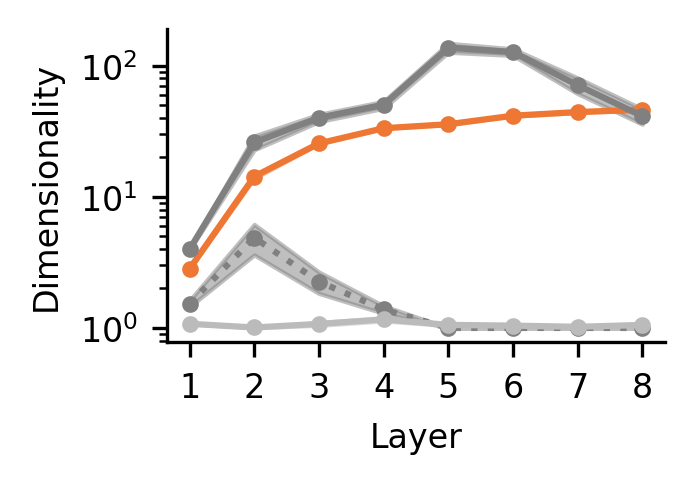

In [26]:
idx_to_plot = global_dim_idx
plt.figure(figsize=(2.2,1.5), dpi=300)

vals = greedy_lpl_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_lpl_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='#EE7733', label='LPL', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#EE7733', alpha=0.5)

vals = greedy_no_pred_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_no_pred_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='gray', label='Pred. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_collapse_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_collapse_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_dimensional_collapse_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_dimensional_collapse_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Dimensionality', fontsize=8)
plt.xticks(range(1,9))

# lgd = plt.legend(frameon=False, fontsize=6, loc=(0.6, 0.1))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')
sns.despine()

# plt.savefig('fig2D.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

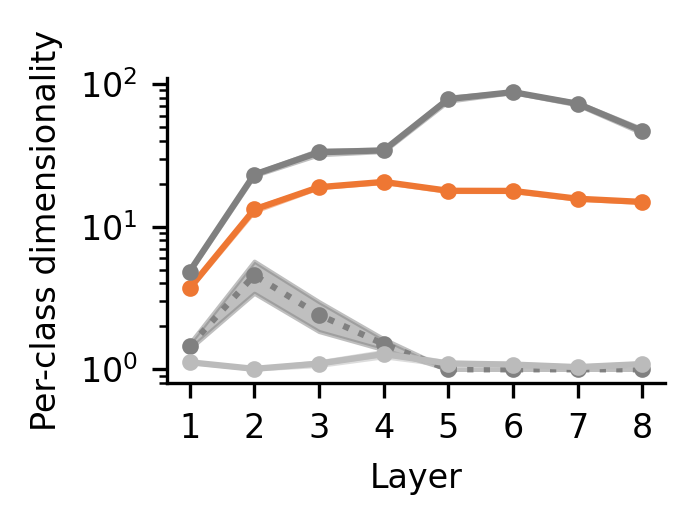

In [27]:
idx_to_plot = classwise_dim_idx
plt.figure(figsize=(2.2,1.5), dpi=300)

vals = greedy_lpl_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_lpl_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='#EE7733', label='LPL', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#EE7733', alpha=0.5)

vals = greedy_no_pred_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_no_pred_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='gray', label='Pred. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_collapse_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_collapse_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_dimensional_collapse_dim.mean(dim=0)[idx_to_plot]
stderrs = greedy_dimensional_collapse_dim.std(dim=0)[idx_to_plot]/2
plt.plot(range(1,9), vals, color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Per-class dimensionality', fontsize=8)
plt.xticks(range(1,9))

# lgd = plt.legend(frameon=False, fontsize=6, loc=(0.6, 0.1))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')
sns.despine()

# plt.savefig('fig2D.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

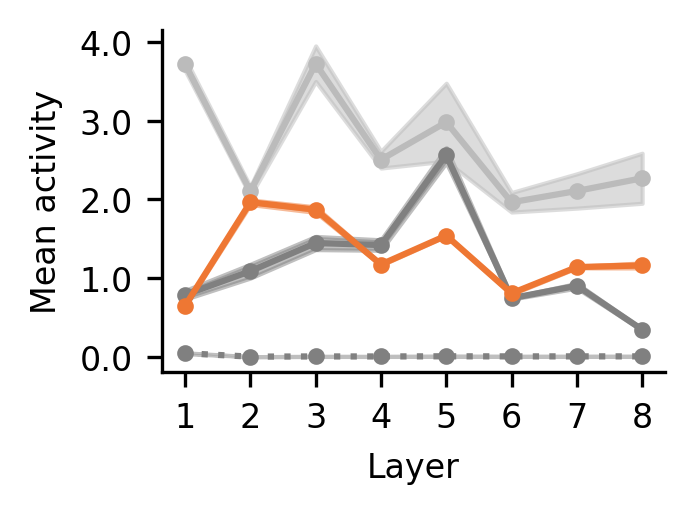

In [28]:
plt.figure(figsize=(2.2,1.6), dpi=300)

vals = greedy_lpl_act.mean(dim=0)
stderrs = greedy_lpl_act.std(dim=0)/2
plt.plot(range(1,9), greedy_lpl_act.mean(dim=0), color='#EE7733', label='LPL', marker='.', zorder=4)
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#EE7733', alpha=0.5)

vals = greedy_no_pred_act.mean(dim=0)
stderrs = greedy_no_pred_act.std(dim=0)/2
plt.plot(range(1,9), greedy_no_pred_act.mean(dim=0), color='gray', label='Pred. off', marker='.', zorder=3)
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_collapse_act.mean(dim=0)
stderrs = greedy_collapse_act.std(dim=0)/2
plt.plot(range(1,9), greedy_collapse_act.mean(dim=0), color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_dimensional_collapse_act.mean(dim=0)
stderrs = greedy_dimensional_collapse_act.std(dim=0)/2
plt.plot(range(1,9), greedy_dimensional_collapse_act.mean(dim=0), color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Mean activity', fontsize=8)
plt.xticks(range(1,9))

# lgd = plt.legend(frameon=False, fontsize=6)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine()

plt.savefig(os.path.join(outputdir,'deep_net_layerwise_act_stl.pdf'), bbox_inches='tight', backend='pgf')

In [32]:
greedy_lpl_dim.mean(dim=0).shape

torch.Size([2, 8])

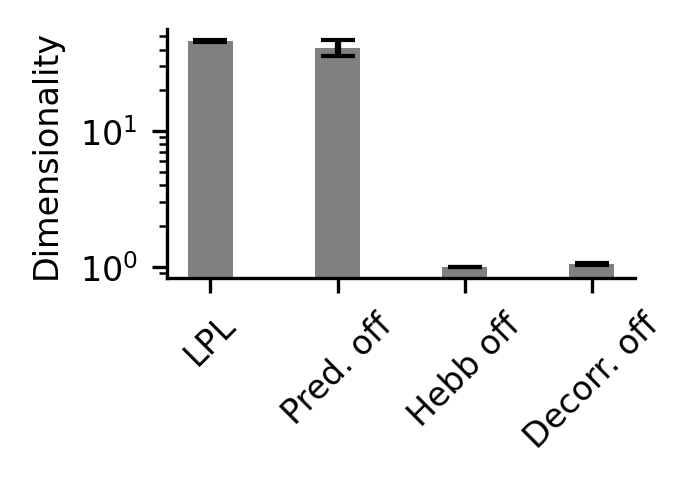

In [36]:
idx_to_plot = global_dim_idx

mean_dims = {}
err_dims = {}

mean_dims['greedy_lpl'] = greedy_lpl_dim.mean(dim=0)[idx_to_plot][-1]
err_dims['greedy_lpl'] = greedy_lpl_dim.std(dim=0)[idx_to_plot][-1]/2

mean_dims['greedy_no_pred'] = greedy_no_pred_dim.mean(dim=0)[idx_to_plot][-1]
err_dims['greedy_no_pred'] = greedy_no_pred_dim.std(dim=0)[idx_to_plot][-1]/2

mean_dims['greedy_collapse'] = greedy_collapse_dim.mean(dim=0)[idx_to_plot][-1]
err_dims['greedy_collapse'] = greedy_collapse_dim.std(dim=0)[idx_to_plot][-1]/2

mean_dims['greedy_dimensional_collapse'] = np.mean(np.array(greedy_dimensional_collapse_dim), axis=0)[idx_to_plot][-1]
err_dims['greedy_dimensional_collapse'] = np.std(np.array(greedy_dimensional_collapse_dim),axis=0)[idx_to_plot][-1]/2

plt.figure(figsize=(2.2, 1.5), dpi=300)

barWidth = 0.35

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]

# plt.figure(figsize=(5.2, 1.5), dpi=200)

plt.bar(r1, [mean_dims['greedy_lpl'], mean_dims['greedy_no_pred'], mean_dims['greedy_collapse'], mean_dims['greedy_dimensional_collapse']], color ='gray', width = barWidth, yerr = [err_dims['greedy_lpl'], err_dims['greedy_no_pred'], err_dims['greedy_collapse'], err_dims['greedy_dimensional_collapse']], label='Layer-local', capsize=4)
plt.xticks(r1, ['LPL', 'Pred. off', 'Hebb off', 'Decorr. off'], fontsize=8)
plt.ylabel('Dimensionality', fontsize=8)
# lgd = plt.legend(frameon=False, fontsize=6)
plt.xticks(rotation=45, fontsize=8)
# plt.tight_layout()
ax = plt.gca()
# plt.ylim(0,0.8)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')
sns.despine()
plt.savefig(os.path.join(outputdir,'deep_net_dim_stl.pdf'), bbox_inches='tight')

In [38]:
mean_dims

{'greedy_lpl': tensor(46.2474),
 'greedy_no_pred': tensor(41.2433),
 'greedy_collapse': tensor(1.),
 'greedy_dimensional_collapse': 1.0538733}

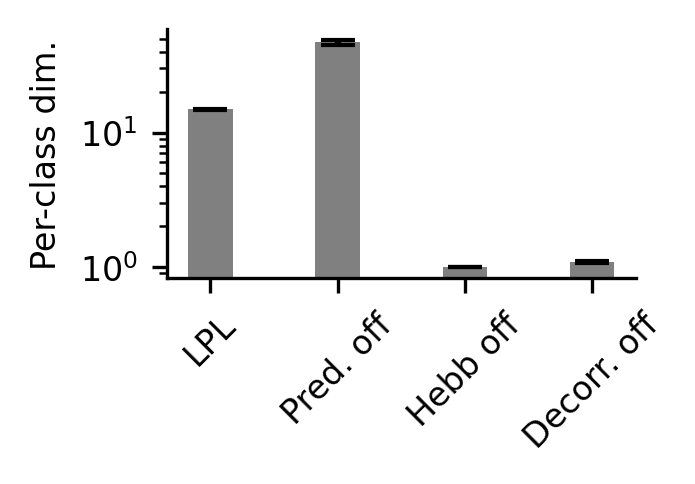

In [39]:
idx_to_plot = classwise_dim_idx

mean_dims = {}
err_dims = {}

mean_dims['greedy_lpl'] = greedy_lpl_dim.mean(dim=0)[idx_to_plot][-1]
err_dims['greedy_lpl'] = greedy_lpl_dim.std(dim=0)[idx_to_plot][-1]/2

mean_dims['greedy_no_pred'] = greedy_no_pred_dim.mean(dim=0)[idx_to_plot][-1]
err_dims['greedy_no_pred'] = greedy_no_pred_dim.std(dim=0)[idx_to_plot][-1]/2

mean_dims['greedy_collapse'] = greedy_collapse_dim.mean(dim=0)[idx_to_plot][-1]
err_dims['greedy_collapse'] = greedy_collapse_dim.std(dim=0)[idx_to_plot][-1]/2

mean_dims['greedy_dimensional_collapse'] = np.mean(np.array(greedy_dimensional_collapse_dim), axis=0)[idx_to_plot][-1]
err_dims['greedy_dimensional_collapse'] = np.std(np.array(greedy_dimensional_collapse_dim),axis=0)[idx_to_plot][-1]/2

plt.figure(figsize=(2.2, 1.5), dpi=300)

barWidth = 0.35

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]

# plt.figure(figsize=(5.2, 1.5), dpi=200)

plt.bar(r1, [mean_dims['greedy_lpl'], mean_dims['greedy_no_pred'], mean_dims['greedy_collapse'], mean_dims['greedy_dimensional_collapse']], color ='gray', width = barWidth, yerr = [err_dims['greedy_lpl'], err_dims['greedy_no_pred'], err_dims['greedy_collapse'], err_dims['greedy_dimensional_collapse']], label='Layer-local', capsize=4)
plt.xticks(r1, ['LPL', 'Pred. off', 'Hebb off', 'Decorr. off'], fontsize=8)
plt.ylabel('Per-class dim.', fontsize=8)
# lgd = plt.legend(frameon=False, fontsize=6)
plt.xticks(rotation=45, fontsize=8)
# plt.tight_layout()
ax = plt.gca()
# plt.ylim(0,0.8)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')
sns.despine()
# plt.savefig('deep_net_dim_stl.pdf', bbox_inches='tight')

In [40]:
mean_dims

{'greedy_lpl': tensor(14.8918),
 'greedy_no_pred': tensor(46.7696),
 'greedy_collapse': tensor(1.),
 'greedy_dimensional_collapse': 1.0879241}

## Point clouds

In [56]:
model = LPL.load_from_checkpoint(os.path.join(prefix,'run_1','lpl','checkpoints/epoch=799-step=74399.ckpt'), strict=False).to('cuda')
encoder_blocks = model.network.encoder.blocks

In [57]:
val_reprs, val_labels, val_pixels = get_representations(data_module.test_dataloader(), encoder_blocks, return_pixels=True)

/ereborfs/manuhalv/venvs/holodeck/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


In [58]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

### UMAP

In [59]:
reducer = umap.UMAP(n_components=3)

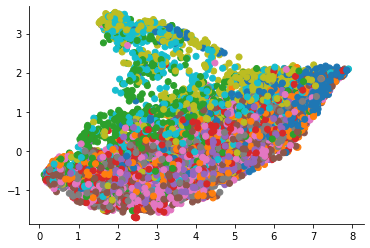

In [60]:
embedding = reducer.fit_transform(val_pixels.cpu())
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in val_labels.cpu()])
sns.despine()
plt.gca().set_aspect('equal', 'datalim')

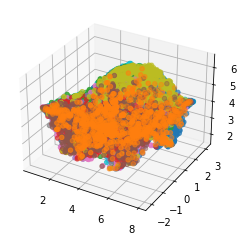

In [61]:
embedding = reducer.fit_transform(val_pixels.cpu())
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(class_names)):
    ax.scatter(
        embedding[val_labels.cpu()==i, 0],
        embedding[val_labels.cpu()==i, 1],
        embedding[val_labels.cpu()==i, 2],
        c=[sns.color_palette()[i]],
        label=class_names[i])
sns.despine()
# plt.axis('off')
# plt.gca().set_aspect('equal', 'datalim')

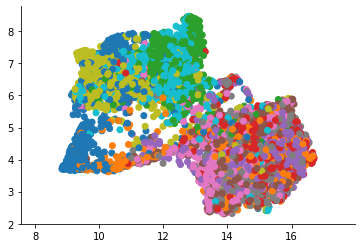

In [62]:
embedding = reducer.fit_transform(val_reprs[3].cpu())
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in val_labels.cpu()])
sns.despine()
plt.gca().set_aspect('equal', 'datalim')

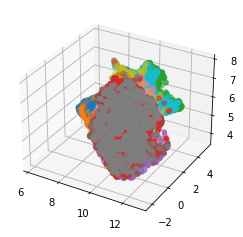

In [63]:
embedding = reducer.fit_transform(val_reprs[3].cpu())
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(class_names)):
    ax.scatter(
        embedding[val_labels.cpu()==i, 0],
        embedding[val_labels.cpu()==i, 1],
        embedding[val_labels.cpu()==i, 2],
        c=[sns.color_palette()[i]],
        label=class_names[i])
sns.despine()
# plt.axis('off')
# plt.gca().set_aspect('equal', 'datalim')

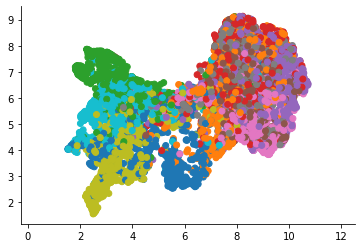

In [64]:
embedding = reducer.fit_transform(val_reprs[-1].cpu())
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in val_labels.cpu()])
sns.despine()
plt.gca().set_aspect('equal', 'datalim')

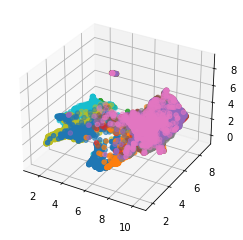

In [65]:
embedding = reducer.fit_transform(val_reprs[-1].cpu())
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(class_names)):
    ax.scatter(
        embedding[val_labels.cpu()==i, 0],
        embedding[val_labels.cpu()==i, 1],
        embedding[val_labels.cpu()==i, 2],
        c=[sns.color_palette()[i]],
        label=class_names[i])
sns.despine()
# plt.axis('off')
# plt.gca().set_aspect('equal', 'datalim')

### PCA

In [66]:
reducer = PCA(n_components=3)

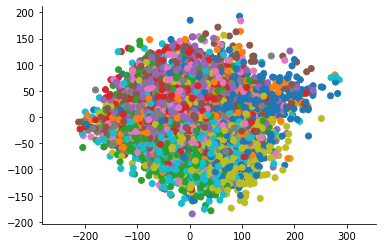

In [67]:
embedding = reducer.fit_transform(val_pixels.cpu())
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in val_labels.cpu()])
sns.despine()
plt.gca().set_aspect('equal', 'datalim')

Text(0.5, 0, 'PC3')

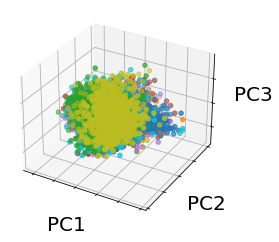

In [49]:
embedding = reducer.fit_transform(val_pixels.cpu())
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(class_names)):
    ax.scatter(
        embedding[val_labels.cpu()==i, 0],
        embedding[val_labels.cpu()==i, 1],
        embedding[val_labels.cpu()==i, 2],
        c=[sns.color_palette()[i]],
        label=class_names[i])
sns.despine()
# plt.axis('off')
# plt.gca().set_aspect('equal', 'datalim')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_zlabel('PC3', fontsize=20)

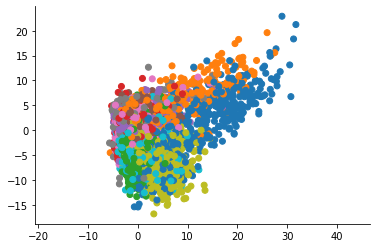

In [68]:
embedding = reducer.fit_transform(val_reprs[3].cpu())
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in val_labels.cpu()])
sns.despine()
plt.gca().set_aspect('equal', 'datalim')

Text(0.5, 0, 'PC3')

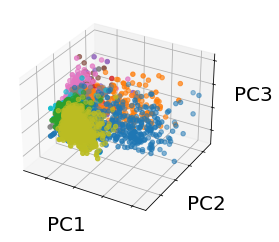

In [51]:
embedding = reducer.fit_transform(val_reprs[3].cpu())
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(class_names)):
    ax.scatter(
        embedding[val_labels.cpu()==i, 0],
        embedding[val_labels.cpu()==i, 1],
        embedding[val_labels.cpu()==i, 2],
        c=[sns.color_palette()[i]],
        label=class_names[i])
sns.despine()
# plt.axis('off')
# plt.gca().set_aspect('equal', 'datalim')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_zlabel('PC3', fontsize=20)
# plt.legend(frameon=False, loc=(1.3,0.1), fontsize=12)

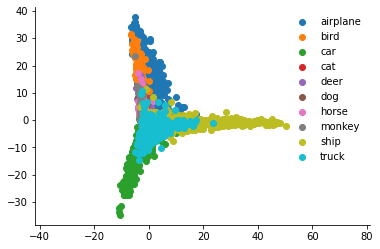

In [74]:
embedding = reducer.fit_transform(val_reprs[-1].cpu())
fig = plt.figure()
ax = fig.add_subplot()
for i in range(len(class_names)):
    ax.scatter(
        embedding[val_labels.cpu()==i, 0],
        embedding[val_labels.cpu()==i, 1],
        c=[sns.color_palette()[i]],
        label=class_names[i])
sns.despine()
plt.gca().set_aspect('equal', 'datalim')
plt.legend(frameon=False)

Text(0.5, 0, 'PC3')

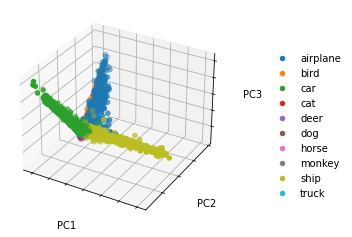

In [25]:
embedding = reducer.fit_transform(val_reprs[-1].cpu())
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(class_names)):
    ax.scatter(
        embedding[val_labels.cpu()==i, 0],
        embedding[val_labels.cpu()==i, 1],
        embedding[val_labels.cpu()==i, 2],
        c=[sns.color_palette()[i]],
        label=class_names[i])
sns.despine()
# plt.axis('off')
# plt.gca().set_aspect('equal', 'datalim')
plt.legend(frameon=False, loc=(1.2,0.1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# CIFAR-10

In [63]:
prefix = os.path.expanduser("~/data/lpl/cifar10")
model_name = 'lpl'

In [64]:
data_dir = os.path.join('../data', 'cifar10')
h = 0  # image size

data_module = CIFAR10DataModule(batch_size=1000, data_dir=data_dir)
(c, h, w) = data_module.size()

data_module.train_transforms = SimCLRTrainDataTransform(h)
data_module.val_transforms = SimCLREvalDataTransform(h)
data_module.test_transforms = SimCLREvalDataTransform(h)
data_module.setup()

### Pixel-space decoding

In [27]:
_, val_labels, val_pixels = get_representations(data_module.val_dataloader(), model.network.encoder.blocks, return_pixels=True)
_, test_labels, test_pixels = get_representations(data_module.test_dataloader(), model.network.encoder.blocks, return_pixels=True)

_, _, pixel_participation_ratio, _ = compute_manifold_measures(val_pixels, val_labels)
pixel_activity = val_pixels.mean()
pixel_unit_variance = val_pixels.var(dim=0).mean()
        
train_dataset = TensorDataset(val_pixels, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=512)

test_dataset = TensorDataset(test_pixels, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=1000)

linear_evaluator = LogisticRegression(val_pixels.shape[1], data_module.num_classes, learning_rate=1e-3, checkpoint_callback=False).to('cuda')

readout_trainer = pl.Trainer(gpus=1, max_epochs=20, checkpoint_callback=False)
readout_trainer.fit(linear_evaluator, train_dataloader)

pixel_readout_acc = readout_trainer.test(linear_evaluator, test_dataloader)[0]['test_acc']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 30 K  


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3184, device='cuda:0'),
 'test_ce_loss': tensor(1.9099, device='cuda:0'),
 'test_loss': tensor(1.9099, device='cuda:0')}
--------------------------------------------------------------------------------



In [28]:
pixel_readout_acc

0.31839999556541443

In [26]:
def evaluate_model(model_type, path):
    
    if model_type == 'lpl':
        model = LPL.load_from_checkpoint(path, strict=False).to('cuda')
        encoder_blocks = model.network.encoder.blocks
    
    elif model_type == 'supervised':
        model = SupervisedBaseline.load_from_checkpoint(path, strict=False).to('cuda')
        encoder_blocks = model.network.encoder.blocks
    
    elif model_type == 'neg-samples':
        model = NegSampleBaseline.load_from_checkpoint(path, strict=False).to('cuda')
        encoder_blocks = model.network.encoder.blocks
        
    val_reprs, val_labels = get_representations(data_module.val_dataloader(), encoder_blocks)
    test_reprs, test_labels = get_representations(data_module.test_dataloader(), encoder_blocks)
    
    test_readout_acc = []
    participation_ratio = []
    activity = []
    unit_variance = []
    for i, layer_repr in enumerate(val_reprs):
        _, _, pr, _ = compute_manifold_measures(layer_repr, val_labels)
        participation_ratio.append(pr)
        activity.append(layer_repr.mean())
        unit_variance.append(layer_repr.var(dim=0).mean())
        
        train_dataset = TensorDataset(layer_repr, val_labels)
        train_dataloader = DataLoader(train_dataset, batch_size=512)

        test_dataset = TensorDataset(test_reprs[i], test_labels)
        test_dataloader = DataLoader(test_dataset, batch_size=1000)

        linear_evaluator = LogisticRegression(layer_repr.shape[1], data_module.num_classes, learning_rate=1e-3, checkpoint_callback=False).to('cuda')

        readout_trainer = pl.Trainer(gpus=1, max_epochs=20, checkpoint_callback=False)
        readout_trainer.fit(linear_evaluator, train_dataloader)

        # test_readout_acc.append(readout_trainer.test(linear_evaluator, test_dataloader)[0]['test_acc'])
        accuracy = 0.
        count = 0.
        linear_evaluator.to('cuda')
        for x in test_dataloader:
            pred = linear_evaluator(x[0].to('cuda'))
            accuracy += (pred.argmax(dim=-1)==x[1]).sum()
            count += len(x[1])

        test_readout_acc.append(accuracy/count)
        
    return test_readout_acc, participation_ratio, activity, unit_variance

In [27]:
prefix = os.path.expanduser("~/data/lpl/cifar10")
model_name = 'lpl'

In [28]:
greedy_lpl_acc, greedy_lpl_dim, greedy_lpl_act, greedy_lpl_var = eval_multi_run('lpl', prefix + 'final_run_', model_name)
greedy_collapse_acc, greedy_collapse_dim, greedy_collapse_act, greedy_collapse_var = eval_multi_run('lpl', prefix + 'final_collapse_', model_name)
greedy_dimensional_collapse_acc, greedy_dimensional_collapse_dim, greedy_dimensional_collapse_act, greedy_dimensional_collapse_var = eval_multi_run('lpl', prefix + 'dimensional_collapse_', model_name)
greedy_no_pred_acc, greedy_no_pred_dim, greedy_no_pred_act, greedy_no_pred_var = eval_multi_run('lpl', prefix + 'final_pred_off_', model_name)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/ereborfs/manuhalv/venvs/pytorch/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


/ereborfs/manuhalv/venvs/pytorch/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/ereborfs/manuhalv/venvs/pytorch/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/ereborfs/manuhalv/venvs/pytorch/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


/ereborfs/manuhalv/venvs/pytorch/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2597, device='cuda:0'),
 'test_ce_loss': tensor(2.0077, device='cuda:0'),
 'test_loss': tensor(2.0077, device='cuda:0')}
--------------------------------------------------------------------------------



/ereborfs/manuhalv/venvs/pytorch/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.4168, device='cuda:0'),
 'test_ce_loss': tensor(1.6366, device='cuda:0'),
 'test_loss': tensor(1.6366, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.4928, device='cuda:0'),
 'test_ce_loss': tensor(1.4077, device='cuda:0'),
 'test_loss': tensor(1.4077, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5331, device='cuda:0'),
 'test_ce_loss': tensor(1.3100, device='cuda:0'),
 'test_loss': tensor(1.3100, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5481, device='cuda:0'),
 'test_ce_loss': tensor(1.2657, device='cuda:0'),
 'test_loss': tensor(1.2657, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5459, device='cuda:0'),
 'test_ce_loss': tensor(1.2839, device='cuda:0'),
 'test_loss': tensor(1.2839, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5363, device='cuda:0'),
 'test_ce_loss': tensor(1.3042, device='cuda:0'),
 'test_loss': tensor(1.3042, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5264, device='cuda:0'),
 'test_ce_loss': tensor(1.3399, device='cuda:0'),
 'test_loss': tensor(1.3399, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2495, device='cuda:0'),
 'test_ce_loss': tensor(2.0165, device='cuda:0'),
 'test_loss': tensor(2.0165, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3974, device='cuda:0'),
 'test_ce_loss': tensor(1.6739, device='cuda:0'),
 'test_loss': tensor(1.6739, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5002, device='cuda:0'),
 'test_ce_loss': tensor(1.3998, device='cuda:0'),
 'test_loss': tensor(1.3998, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5307, device='cuda:0'),
 'test_ce_loss': tensor(1.3189, device='cuda:0'),
 'test_loss': tensor(1.3189, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5491, device='cuda:0'),
 'test_ce_loss': tensor(1.2690, device='cuda:0'),
 'test_loss': tensor(1.2690, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5450, device='cuda:0'),
 'test_ce_loss': tensor(1.2837, device='cuda:0'),
 'test_loss': tensor(1.2837, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5414, device='cuda:0'),
 'test_ce_loss': tensor(1.3022, device='cuda:0'),
 'test_loss': tensor(1.3022, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5338, device='cuda:0'),
 'test_ce_loss': tensor(1.3128, device='cuda:0'),
 'test_loss': tensor(1.3128, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2522, device='cuda:0'),
 'test_ce_loss': tensor(2.0100, device='cuda:0'),
 'test_loss': tensor(2.0100, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.4035, device='cuda:0'),
 'test_ce_loss': tensor(1.6636, device='cuda:0'),
 'test_loss': tensor(1.6636, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.4981, device='cuda:0'),
 'test_ce_loss': tensor(1.4033, device='cuda:0'),
 'test_loss': tensor(1.4033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5379, device='cuda:0'),
 'test_ce_loss': tensor(1.3042, device='cuda:0'),
 'test_loss': tensor(1.3042, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5561, device='cuda:0'),
 'test_ce_loss': tensor(1.2538, device='cuda:0'),
 'test_loss': tensor(1.2538, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5529, device='cuda:0'),
 'test_ce_loss': tensor(1.2684, device='cuda:0'),
 'test_loss': tensor(1.2684, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5445, device='cuda:0'),
 'test_ce_loss': tensor(1.2851, device='cuda:0'),
 'test_loss': tensor(1.2851, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5445, device='cuda:0'),
 'test_ce_loss': tensor(1.3011, device='cuda:0'),
 'test_loss': tensor(1.3011, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2485, device='cuda:0'),
 'test_ce_loss': tensor(2.0092, device='cuda:0'),
 'test_loss': tensor(2.0092, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.4088, device='cuda:0'),
 'test_ce_loss': tensor(1.6628, device='cuda:0'),
 'test_loss': tensor(1.6628, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.4987, device='cuda:0'),
 'test_ce_loss': tensor(1.3997, device='cuda:0'),
 'test_loss': tensor(1.3997, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5347, device='cuda:0'),
 'test_ce_loss': tensor(1.3044, device='cuda:0'),
 'test_loss': tensor(1.3044, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5567, device='cuda:0'),
 'test_ce_loss': tensor(1.2564, device='cuda:0'),
 'test_loss': tensor(1.2564, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5499, device='cuda:0'),
 'test_ce_loss': tensor(1.2771, device='cuda:0'),
 'test_loss': tensor(1.2771, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5422, device='cuda:0'),
 'test_ce_loss': tensor(1.2959, device='cuda:0'),
 'test_loss': tensor(1.2959, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.5359, device='cuda:0'),
 'test_ce_loss': tensor(1.3104, device='cuda:0'),
 'test_loss': tensor(1.3104, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3030, device='cuda:0'),
 'test_loss': tensor(2.3030, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3032, device='cuda:0'),
 'test_loss': tensor(2.3032, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3032, device='cuda:0'),
 'test_loss': tensor(2.3032, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3032, device='cuda:0'),
 'test_loss': tensor(2.3032, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3032, device='cuda:0'),
 'test_loss': tensor(2.3032, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3031, device='cuda:0'),
 'test_loss': tensor(2.3031, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3030, device='cuda:0'),
 'test_loss': tensor(2.3030, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3032, device='cuda:0'),
 'test_loss': tensor(2.3032, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1000, device='cuda:0'),
 'test_ce_loss': tensor(2.3033, device='cuda:0'),
 'test_loss': tensor(2.3033, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1955, device='cuda:0'),
 'test_ce_loss': tensor(2.1100, device='cuda:0'),
 'test_loss': tensor(2.1100, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1964, device='cuda:0'),
 'test_ce_loss': tensor(2.0971, device='cuda:0'),
 'test_loss': tensor(2.0971, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2030, device='cuda:0'),
 'test_ce_loss': tensor(2.0901, device='cuda:0'),
 'test_loss': tensor(2.0901, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2266, device='cuda:0'),
 'test_ce_loss': tensor(2.0574, device='cuda:0'),
 'test_loss': tensor(2.0574, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2074, device='cuda:0'),
 'test_ce_loss': tensor(2.0722, device='cuda:0'),
 'test_loss': tensor(2.0722, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1760, device='cuda:0'),
 'test_ce_loss': tensor(2.1146, device='cuda:0'),
 'test_loss': tensor(2.1146, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1873, device='cuda:0'),
 'test_ce_loss': tensor(2.0786, device='cuda:0'),
 'test_loss': tensor(2.0786, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1996, device='cuda:0'),
 'test_ce_loss': tensor(2.0791, device='cuda:0'),
 'test_loss': tensor(2.0791, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1949, device='cuda:0'),
 'test_ce_loss': tensor(2.1344, device='cuda:0'),
 'test_loss': tensor(2.1344, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1894, device='cuda:0'),
 'test_ce_loss': tensor(2.0960, device='cuda:0'),
 'test_loss': tensor(2.0960, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2188, device='cuda:0'),
 'test_ce_loss': tensor(2.0534, device='cuda:0'),
 'test_loss': tensor(2.0534, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2249, device='cuda:0'),
 'test_ce_loss': tensor(2.0672, device='cuda:0'),
 'test_loss': tensor(2.0672, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2242, device='cuda:0'),
 'test_ce_loss': tensor(2.0678, device='cuda:0'),
 'test_loss': tensor(2.0678, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1746, device='cuda:0'),
 'test_ce_loss': tensor(2.0894, device='cuda:0'),
 'test_loss': tensor(2.0894, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2007, device='cuda:0'),
 'test_ce_loss': tensor(2.0796, device='cuda:0'),
 'test_loss': tensor(2.0796, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1722, device='cuda:0'),
 'test_ce_loss': tensor(2.0961, device='cuda:0'),
 'test_loss': tensor(2.0961, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1907, device='cuda:0'),
 'test_ce_loss': tensor(2.1204, device='cuda:0'),
 'test_loss': tensor(2.1204, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1951, device='cuda:0'),
 'test_ce_loss': tensor(2.0965, device='cuda:0'),
 'test_loss': tensor(2.0965, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1987, device='cuda:0'),
 'test_ce_loss': tensor(2.0895, device='cuda:0'),
 'test_loss': tensor(2.0895, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2465, device='cuda:0'),
 'test_ce_loss': tensor(2.0389, device='cuda:0'),
 'test_loss': tensor(2.0389, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1649, device='cuda:0'),
 'test_ce_loss': tensor(2.1138, device='cuda:0'),
 'test_loss': tensor(2.1138, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2354, device='cuda:0'),
 'test_ce_loss': tensor(2.0354, device='cuda:0'),
 'test_loss': tensor(2.0354, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2090, device='cuda:0'),
 'test_ce_loss': tensor(2.0707, device='cuda:0'),
 'test_loss': tensor(2.0707, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1861, device='cuda:0'),
 'test_ce_loss': tensor(2.0823, device='cuda:0'),
 'test_loss': tensor(2.0823, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1796, device='cuda:0'),
 'test_ce_loss': tensor(2.1118, device='cuda:0'),
 'test_loss': tensor(2.1118, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1963, device='cuda:0'),
 'test_ce_loss': tensor(2.0951, device='cuda:0'),
 'test_loss': tensor(2.0951, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2210, device='cuda:0'),
 'test_ce_loss': tensor(2.0614, device='cuda:0'),
 'test_loss': tensor(2.0614, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2389, device='cuda:0'),
 'test_ce_loss': tensor(2.0291, device='cuda:0'),
 'test_loss': tensor(2.0291, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2221, device='cuda:0'),
 'test_ce_loss': tensor(2.0708, device='cuda:0'),
 'test_loss': tensor(2.0708, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1992, device='cuda:0'),
 'test_ce_loss': tensor(2.0735, device='cuda:0'),
 'test_loss': tensor(2.0735, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1849, device='cuda:0'),
 'test_ce_loss': tensor(2.0825, device='cuda:0'),
 'test_loss': tensor(2.0825, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2080, device='cuda:0'),
 'test_ce_loss': tensor(2.0708, device='cuda:0'),
 'test_loss': tensor(2.0708, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2639, device='cuda:0'),
 'test_ce_loss': tensor(2.0011, device='cuda:0'),
 'test_loss': tensor(2.0011, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3378, device='cuda:0'),
 'test_ce_loss': tensor(1.8509, device='cuda:0'),
 'test_loss': tensor(1.8509, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3752, device='cuda:0'),
 'test_ce_loss': tensor(1.8093, device='cuda:0'),
 'test_loss': tensor(1.8093, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2856, device='cuda:0'),
 'test_ce_loss': tensor(2.1143, device='cuda:0'),
 'test_loss': tensor(2.1143, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2556, device='cuda:0'),
 'test_ce_loss': tensor(2.2227, device='cuda:0'),
 'test_loss': tensor(2.2227, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2171, device='cuda:0'),
 'test_ce_loss': tensor(2.6394, device='cuda:0'),
 'test_loss': tensor(2.6394, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1961, device='cuda:0'),
 'test_ce_loss': tensor(2.7413, device='cuda:0'),
 'test_loss': tensor(2.7413, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1813, device='cuda:0'),
 'test_ce_loss': tensor(3.0356, device='cuda:0'),
 'test_loss': tensor(3.0356, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2587, device='cuda:0'),
 'test_ce_loss': tensor(2.0006, device='cuda:0'),
 'test_loss': tensor(2.0006, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3395, device='cuda:0'),
 'test_ce_loss': tensor(1.8277, device='cuda:0'),
 'test_loss': tensor(1.8277, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3837, device='cuda:0'),
 'test_ce_loss': tensor(1.7992, device='cuda:0'),
 'test_loss': tensor(1.7992, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2976, device='cuda:0'),
 'test_ce_loss': tensor(2.1280, device='cuda:0'),
 'test_loss': tensor(2.1280, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2631, device='cuda:0'),
 'test_ce_loss': tensor(2.2131, device='cuda:0'),
 'test_loss': tensor(2.2131, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2316, device='cuda:0'),
 'test_ce_loss': tensor(2.6516, device='cuda:0'),
 'test_loss': tensor(2.6516, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2034, device='cuda:0'),
 'test_ce_loss': tensor(2.8032, device='cuda:0'),
 'test_loss': tensor(2.8032, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1885, device='cuda:0'),
 'test_ce_loss': tensor(3.0630, device='cuda:0'),
 'test_loss': tensor(3.0630, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2677, device='cuda:0'),
 'test_ce_loss': tensor(1.9990, device='cuda:0'),
 'test_loss': tensor(1.9990, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3449, device='cuda:0'),
 'test_ce_loss': tensor(1.8179, device='cuda:0'),
 'test_loss': tensor(1.8179, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3793, device='cuda:0'),
 'test_ce_loss': tensor(1.8252, device='cuda:0'),
 'test_loss': tensor(1.8252, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2923, device='cuda:0'),
 'test_ce_loss': tensor(2.1225, device='cuda:0'),
 'test_loss': tensor(2.1225, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2611, device='cuda:0'),
 'test_ce_loss': tensor(2.2147, device='cuda:0'),
 'test_loss': tensor(2.2147, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2251, device='cuda:0'),
 'test_ce_loss': tensor(2.6443, device='cuda:0'),
 'test_loss': tensor(2.6443, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2038, device='cuda:0'),
 'test_ce_loss': tensor(2.7047, device='cuda:0'),
 'test_loss': tensor(2.7047, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1812, device='cuda:0'),
 'test_ce_loss': tensor(2.9900, device='cuda:0'),
 'test_loss': tensor(2.9900, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 650   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2674, device='cuda:0'),
 'test_ce_loss': tensor(2.0013, device='cuda:0'),
 'test_loss': tensor(2.0013, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3618, device='cuda:0'),
 'test_ce_loss': tensor(1.8062, device='cuda:0'),
 'test_loss': tensor(1.8062, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3894, device='cuda:0'),
 'test_ce_loss': tensor(1.7886, device='cuda:0'),
 'test_loss': tensor(1.7886, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 2 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.3096, device='cuda:0'),
 'test_ce_loss': tensor(2.0917, device='cuda:0'),
 'test_loss': tensor(2.0917, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2708, device='cuda:0'),
 'test_ce_loss': tensor(2.1797, device='cuda:0'),
 'test_loss': tensor(2.1797, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2335, device='cuda:0'),
 'test_ce_loss': tensor(2.5903, device='cuda:0'),
 'test_loss': tensor(2.5903, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.2110, device='cuda:0'),
 'test_ce_loss': tensor(2.7126, device='cuda:0'),
 'test_loss': tensor(2.7126, device='cuda:0')}
--------------------------------------------------------------------------------



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 5 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.1878, device='cuda:0'),
 'test_ce_loss': tensor(3.0529, device='cuda:0'),
 'test_loss': tensor(3.0529, device='cuda:0')}
--------------------------------------------------------------------------------



In [29]:
plt.rcParams['figure.constrained_layout.use'] = True

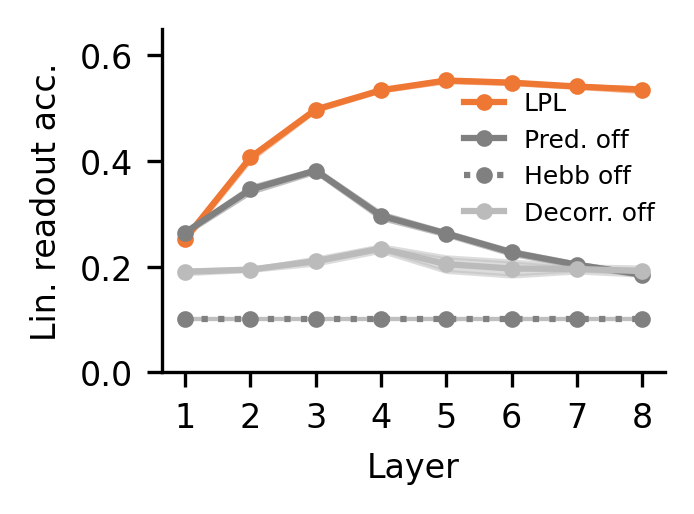

In [30]:
plt.figure(figsize=(2.2,1.6), dpi=300)

vals = greedy_lpl_acc.mean(dim=0)
stderrs = greedy_lpl_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_lpl_acc.mean(dim=0), color='#EE7733', label='LPL', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#EE7733', alpha=0.5)

vals = greedy_no_pred_acc.mean(dim=0)
stderrs = greedy_no_pred_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_no_pred_acc.mean(dim=0), color='gray', label='Pred. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_collapse_acc.mean(dim=0)
stderrs = greedy_collapse_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_collapse_acc.mean(dim=0), color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_dimensional_collapse_acc.mean(dim=0)
stderrs = greedy_dimensional_collapse_acc.std(dim=0)/2
plt.plot(range(1,9), greedy_dimensional_collapse_acc.mean(dim=0), color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Lin. readout acc.', fontsize=8)
plt.xticks(range(1,9))
plt.ylim(0,0.65)

lgd = plt.legend(frameon=False, fontsize=6, handlelength=1.6, loc=(0.58,0.4))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
sns.despine()

plt.savefig('deep_net_layerwise_acc_cifar.pdf', bbox_inches='tight', backend='pgf')

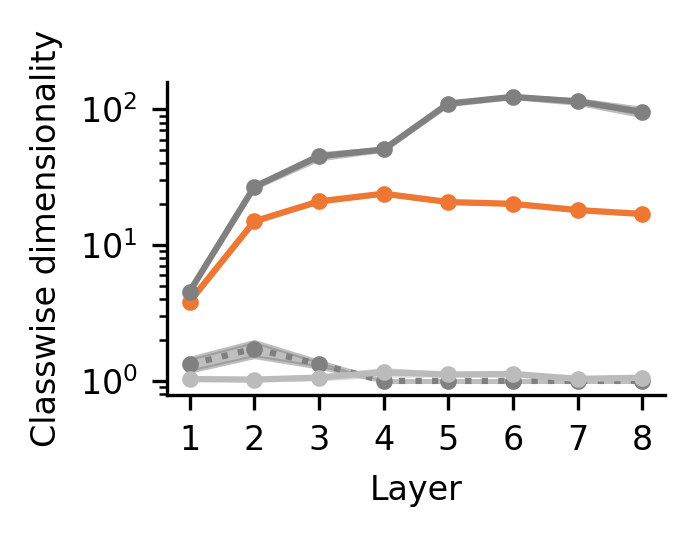

In [23]:
plt.figure(figsize=(2.2,1.5), dpi=300)

vals = greedy_lpl_dim.mean(dim=0)
stderrs = greedy_lpl_dim.std(dim=0)/2
plt.plot(range(1,9), greedy_lpl_dim.mean(dim=0), color='#EE7733', label='LPL', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#EE7733', alpha=0.5)

vals = greedy_no_pred_dim.mean(dim=0)
stderrs = greedy_no_pred_dim.std(dim=0)/2
plt.plot(range(1,9), greedy_no_pred_dim.mean(dim=0), color='gray', label='Pred. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_collapse_dim.mean(dim=0)
stderrs = greedy_collapse_dim.std(dim=0)/2
plt.plot(range(1,9), greedy_collapse_dim.mean(dim=0), color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_dimensional_collapse_dim.mean(dim=0)
stderrs = greedy_dimensional_collapse_dim.std(dim=0)/2
plt.plot(range(1,9), greedy_dimensional_collapse_dim.mean(dim=0), color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Classwise dimensionality', fontsize=8)
plt.xticks(range(1,9))

# lgd = plt.legend(frameon=False, fontsize=6, loc=(0.6, 0.1))
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')
sns.despine()

# plt.savefig('fig2D.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

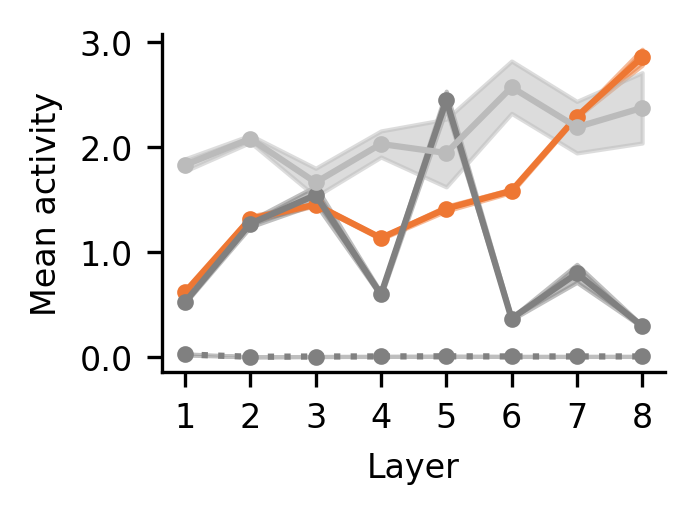

In [32]:
plt.figure(figsize=(2.2,1.6), dpi=300)

vals = greedy_lpl_act.mean(dim=0)
stderrs = greedy_lpl_act.std(dim=0)/2
plt.plot(range(1,9), greedy_lpl_act.mean(dim=0), color='#EE7733', label='LPL', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#EE7733', alpha=0.5)

vals = greedy_no_pred_act.mean(dim=0)
stderrs = greedy_no_pred_act.std(dim=0)/2
plt.plot(range(1,9), greedy_no_pred_act.mean(dim=0), color='gray', label='Pred. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_collapse_act.mean(dim=0)
stderrs = greedy_collapse_act.std(dim=0)/2
plt.plot(range(1,9), greedy_collapse_act.mean(dim=0), color='gray', label='Hebb off', marker='.', linestyle=':')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='gray', alpha=0.5)

vals = greedy_dimensional_collapse_act.mean(dim=0)
stderrs = greedy_dimensional_collapse_act.std(dim=0)/2
plt.plot(range(1,9), greedy_dimensional_collapse_act.mean(dim=0), color='#BBBBBB', label='Decorr. off', marker='.')
plt.fill_between(range(1,9), vals-stderrs, vals+stderrs, color='#BBBBBB', alpha=0.5)

plt.xlabel('Layer', fontsize=8)
plt.ylabel('Mean activity', fontsize=8)
plt.xticks(range(1,9))

# lgd = plt.legend(frameon=False, fontsize=6)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine()

plt.savefig('deep_net_layerwise_act_cifar.pdf', bbox_inches='tight', backend='pgf')

## Participation ratio bar plots

In [141]:
model_name = 'lpl_end-to-end'
greedy_model_name = 'lpl'

In [155]:
greedy_lpl_dim = eval_dim_multi_run('lpl', prefix + 'final_run_', greedy_model_name)
greedy_collapse_dim = eval_dim_multi_run('lpl', prefix + 'final_collapse_', greedy_model_name)
greedy_dimensional_collapse_dim = eval_dim_multi_run('lpl', prefix + 'dimensional_collapse_', greedy_model_name)
greedy_no_pred_dim = eval_dim_multi_run('lpl', prefix + 'final_pred_off_', greedy_model_name)

# lpl_dim = eval_dim_multi_run('lpl', prefix + 'run_', greedy_model_name)
# collapse_dim = eval_dim_multi_run('lpl', prefix + 'collapse_', model_name)
# dimensional_collapse_dim = eval_dim_multi_run('lpl', prefix + 'decorr_off_', model_name)
# no_pred_dim = eval_dim_multi_run('lpl', prefix + 'pred_off_', model_name)

In [156]:
mean_dims = {}
err_dims = {}

In [157]:
mean_dims['greedy_lpl'] = greedy_lpl_dim.mean(dim=0)[-1]
err_dims['greedy_lpl'] = greedy_lpl_dim.std(dim=0)[-1]/2

mean_dims['greedy_no_pred'] = greedy_no_pred_dim.mean(dim=0)[-1]
err_dims['greedy_no_pred'] = greedy_no_pred_dim.std(dim=0)[-1]/2

mean_dims['greedy_collapse'] = greedy_collapse_dim.mean(dim=0)[-1]
err_dims['greedy_collapse'] = greedy_collapse_dim.std(dim=0)[-1]/2

mean_dims['greedy_dimensional_collapse'] = np.mean(np.array(greedy_dimensional_collapse_dim), axis=0)[-1]
err_dims['greedy_dimensional_collapse'] = np.std(np.array(greedy_dimensional_collapse_dim),axis=0)[-1]/2

# mean_dims['lpl'] = lpl_dim.mean(dim=0)[-1]
# err_dims['lpl'] = lpl_dim.std(dim=0)[-1]/2

# mean_dims['no_pred'] = no_pred_dim.mean(dim=0)[-1]
# err_dims['no_pred'] = no_pred_dim.std(dim=0)[-1]/2

# mean_dims['collapse'] = collapse_dim.mean(dim=0)[-1]
# err_dims['collapse'] = collapse_dim.std(dim=0)[-1]/2

# mean_dims['dimensional_collapse'] = dimensional_collapse_dim.mean(dim=0)[-1]
# err_dims['dimensional_collapse'] = dimensional_collapse_dim.std(dim=0)[-1]/2

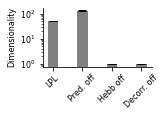

In [158]:
plt.figure(figsize=(2.2, 1.5), dpi=300)

barWidth = 0.35

r1 = np.arange(4)
r2 = [x + barWidth for x in r1]

# plt.figure(figsize=(5.2, 1.5), dpi=200)

plt.bar(r1, [mean_dims['greedy_lpl'], mean_dims['greedy_no_pred'], mean_dims['greedy_collapse'], mean_dims['greedy_dimensional_collapse']], color ='gray', width = barWidth, yerr = [err_dims['greedy_lpl'], err_dims['greedy_no_pred'], err_dims['greedy_collapse'], err_dims['greedy_dimensional_collapse']], label='Layer-local', capsize=4, error_kw={'elinewidth':1, 'capwidth':1})
# plt.bar(r2, [mean_dims['lpl'], mean_dims['no_pred'], mean_dims['collapse'], mean_dims['dimensional_collapse']], color ='gray', width = barWidth, yerr = [err_dims['lpl'], err_dims['no_pred'], err_dims['collapse'], err_dims['dimensional_collapse']], label='End-to-end', alpha=0.5, capsize=4, error_kw={'elinewidth':1, 'capwidth':1})
# plt.xticks([r + 0.5*barWidth for r in range(len(r1))], ['LPL', 'Pred. off', 'Hebb off', 'Decorr. off'], fontsize=8)
plt.xticks(r1, ['LPL', 'Pred. off', 'Hebb off', 'Decorr. off'], fontsize=8)
# plt.hlines(0.1, -0.2, 3.6, color='k', linestyle='--', label='Chance level')
# plt.hlines(mean_accs['supervised'], -0.2, 2.6, color='k', linestyle='-.', label='Supervised')
# plt.ylim(0.45, 1.0)
plt.ylabel('Dimensionality', fontsize=8)
# lgd = plt.legend(frameon=False, fontsize=6)
plt.xticks(rotation=45, fontsize=8)
# plt.tight_layout()
ax = plt.gca()
# plt.ylim(0,0.8)
ax.tick_params(axis = 'both', which = 'major', labelsize=8)
ax.set_yscale('log')
sns.despine()
plt.savefig('deep_net_dim_cifar.pdf', bbox_inches='tight')